<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[02:58:51] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


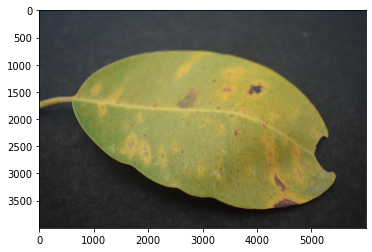

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

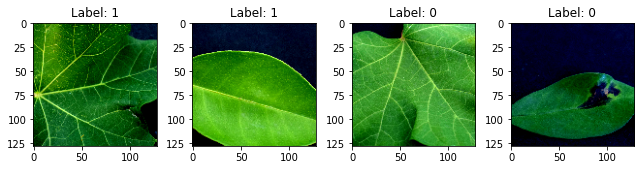

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[02:58:57] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[02:58:59] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2458578192815792 samples/sec                   batch loss = 0.332775354385376 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2736351281612535 samples/sec                   batch loss = 0.6052552461624146 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2687865068254722 samples/sec                   batch loss = 0.5556649565696716 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.267084672596469 samples/sec                   batch loss = 0.47430598735809326 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.246764488276537 samples/sec                   batch loss = 0.5806539058685303 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2710046784976081 samples/sec                   batch loss = 0.5258608460426331 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.232323253097589 samples/sec                   batch loss = 0.26829463243484497 | accuracy = 0.5928571428571429


Epoch[1] Batch[40] Speed: 1.2803284045483467 samples/sec                   batch loss = 0.8528311848640442 | accuracy = 0.6125


Epoch[1] Batch[45] Speed: 1.2682843932194943 samples/sec                   batch loss = 0.8661190867424011 | accuracy = 0.6111111111111112


Epoch[1] Batch[50] Speed: 1.273843910611734 samples/sec                   batch loss = 0.3632987439632416 | accuracy = 0.615


Epoch[1] Batch[55] Speed: 1.2711851487601615 samples/sec                   batch loss = 1.166243314743042 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.2762786242324131 samples/sec                   batch loss = 0.6297939419746399 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2758118928289224 samples/sec                   batch loss = 0.3682137429714203 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.2751779027747323 samples/sec                   batch loss = 0.8134030103683472 | accuracy = 0.6214285714285714


Epoch[1] Batch[75] Speed: 1.2759965452631072 samples/sec                   batch loss = 0.4246678352355957 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.2795158082268672 samples/sec                   batch loss = 0.45590516924858093 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.2797106123157576 samples/sec                   batch loss = 0.5706061124801636 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.2761717379330604 samples/sec                   batch loss = 0.4450676739215851 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.2742023559490896 samples/sec                   batch loss = 1.0918399095535278 | accuracy = 0.6473684210526316


Epoch[1] Batch[100] Speed: 1.2767565792983324 samples/sec                   batch loss = 0.3245135545730591 | accuracy = 0.6475


Epoch[1] Batch[105] Speed: 1.2736980748100657 samples/sec                   batch loss = 1.4854809045791626 | accuracy = 0.6428571428571429


Epoch[1] Batch[110] Speed: 1.2804976543465607 samples/sec                   batch loss = 0.5780906677246094 | accuracy = 0.6409090909090909


Epoch[1] Batch[115] Speed: 1.2817429952352197 samples/sec                   batch loss = 0.4418905973434448 | accuracy = 0.6434782608695652


Epoch[1] Batch[120] Speed: 1.2807227711744977 samples/sec                   batch loss = 0.6525790095329285 | accuracy = 0.6395833333333333


Epoch[1] Batch[125] Speed: 1.2716567897313729 samples/sec                   batch loss = 0.5937647223472595 | accuracy = 0.636


Epoch[1] Batch[130] Speed: 1.2755768609367695 samples/sec                   batch loss = 0.8219486474990845 | accuracy = 0.6346153846153846


Epoch[1] Batch[135] Speed: 1.2815664654803054 samples/sec                   batch loss = 0.8029659986495972 | accuracy = 0.6333333333333333


Epoch[1] Batch[140] Speed: 1.2765884140801698 samples/sec                   batch loss = 0.6357102990150452 | accuracy = 0.6357142857142857


Epoch[1] Batch[145] Speed: 1.2750045331728699 samples/sec                   batch loss = 0.5427567362785339 | accuracy = 0.6362068965517241


Epoch[1] Batch[150] Speed: 1.281108478641989 samples/sec                   batch loss = 0.5269379615783691 | accuracy = 0.6333333333333333


Epoch[1] Batch[155] Speed: 1.2773796914852171 samples/sec                   batch loss = 1.2881957292556763 | accuracy = 0.635483870967742


Epoch[1] Batch[160] Speed: 1.2803027082895653 samples/sec                   batch loss = 0.8981848359107971 | accuracy = 0.6296875


Epoch[1] Batch[165] Speed: 1.2790822015300454 samples/sec                   batch loss = 0.6845752000808716 | accuracy = 0.6303030303030303


Epoch[1] Batch[170] Speed: 1.277789274035088 samples/sec                   batch loss = 0.6166663765907288 | accuracy = 0.6323529411764706


Epoch[1] Batch[175] Speed: 1.2782395339914236 samples/sec                   batch loss = 0.5069996118545532 | accuracy = 0.6385714285714286


Epoch[1] Batch[180] Speed: 1.2754381910403465 samples/sec                   batch loss = 0.24417008459568024 | accuracy = 0.6444444444444445


Epoch[1] Batch[185] Speed: 1.2789934678938808 samples/sec                   batch loss = 0.6841616034507751 | accuracy = 0.6432432432432432


Epoch[1] Batch[190] Speed: 1.2767552190321974 samples/sec                   batch loss = 0.9804866313934326 | accuracy = 0.6421052631578947


Epoch[1] Batch[195] Speed: 1.277465866851501 samples/sec                   batch loss = 1.0130685567855835 | accuracy = 0.6371794871794871


Epoch[1] Batch[200] Speed: 1.2719689685114213 samples/sec                   batch loss = 0.49692603945732117 | accuracy = 0.64


Epoch[1] Batch[205] Speed: 1.2810207352110705 samples/sec                   batch loss = 0.5423736572265625 | accuracy = 0.6439024390243903


Epoch[1] Batch[210] Speed: 1.2765787005163773 samples/sec                   batch loss = 0.3392658829689026 | accuracy = 0.6452380952380953


Epoch[1] Batch[215] Speed: 1.2821543033005973 samples/sec                   batch loss = 0.46182599663734436 | accuracy = 0.6488372093023256


Epoch[1] Batch[220] Speed: 1.2773730780548882 samples/sec                   batch loss = 0.5700464248657227 | accuracy = 0.6454545454545455


Epoch[1] Batch[225] Speed: 1.269198853597675 samples/sec                   batch loss = 0.47042644023895264 | accuracy = 0.6488888888888888


Epoch[1] Batch[230] Speed: 1.2721123830133443 samples/sec                   batch loss = 0.872225284576416 | accuracy = 0.6489130434782608


Epoch[1] Batch[235] Speed: 1.2744348485571277 samples/sec                   batch loss = 0.8454316258430481 | accuracy = 0.652127659574468


Epoch[1] Batch[240] Speed: 1.2777545320212877 samples/sec                   batch loss = 0.6605059504508972 | accuracy = 0.6489583333333333


Epoch[1] Batch[245] Speed: 1.2745442520290875 samples/sec                   batch loss = 0.7550644278526306 | accuracy = 0.65


Epoch[1] Batch[250] Speed: 1.2728381489953304 samples/sec                   batch loss = 0.8255459666252136 | accuracy = 0.652


Epoch[1] Batch[255] Speed: 1.2730975794687374 samples/sec                   batch loss = 0.564827024936676 | accuracy = 0.6509803921568628


Epoch[1] Batch[260] Speed: 1.2788031708910126 samples/sec                   batch loss = 0.4332958459854126 | accuracy = 0.6490384615384616


Epoch[1] Batch[265] Speed: 1.274351404730831 samples/sec                   batch loss = 0.7190179824829102 | accuracy = 0.6481132075471698


Epoch[1] Batch[270] Speed: 1.2772057227093192 samples/sec                   batch loss = 0.4123176336288452 | accuracy = 0.6472222222222223


Epoch[1] Batch[275] Speed: 1.2763365891403162 samples/sec                   batch loss = 0.4780759811401367 | accuracy = 0.6481818181818182


Epoch[1] Batch[280] Speed: 1.2805398760494269 samples/sec                   batch loss = 0.5768951773643494 | accuracy = 0.65


Epoch[1] Batch[285] Speed: 1.277191818921699 samples/sec                   batch loss = 0.5911068320274353 | accuracy = 0.6526315789473685


Epoch[1] Batch[290] Speed: 1.2788019037339895 samples/sec                   batch loss = 0.7140766382217407 | accuracy = 0.6508620689655172


Epoch[1] Batch[295] Speed: 1.2731477198868244 samples/sec                   batch loss = 0.36895403265953064 | accuracy = 0.6516949152542373


Epoch[1] Batch[300] Speed: 1.2710060265379792 samples/sec                   batch loss = 0.18612821400165558 | accuracy = 0.6525


Epoch[1] Batch[305] Speed: 1.2758527388160708 samples/sec                   batch loss = 0.2126081883907318 | accuracy = 0.6565573770491804


Epoch[1] Batch[310] Speed: 1.2746310136213657 samples/sec                   batch loss = 0.9154786467552185 | accuracy = 0.6588709677419354


Epoch[1] Batch[315] Speed: 1.2759684024491098 samples/sec                   batch loss = 0.8337596654891968 | accuracy = 0.6587301587301587


Epoch[1] Batch[320] Speed: 1.2758530298894972 samples/sec                   batch loss = 0.5080776810646057 | accuracy = 0.65859375


Epoch[1] Batch[325] Speed: 1.272283037281273 samples/sec                   batch loss = 0.5993148684501648 | accuracy = 0.6584615384615384


Epoch[1] Batch[330] Speed: 1.2706585193690187 samples/sec                   batch loss = 0.669148862361908 | accuracy = 0.6583333333333333


Epoch[1] Batch[335] Speed: 1.2755858803729192 samples/sec                   batch loss = 0.7635403275489807 | accuracy = 0.658955223880597


Epoch[1] Batch[340] Speed: 1.2761183500291966 samples/sec                   batch loss = 0.4826677143573761 | accuracy = 0.6595588235294118


Epoch[1] Batch[345] Speed: 1.2824731285703845 samples/sec                   batch loss = 0.5255639553070068 | accuracy = 0.6623188405797101


Epoch[1] Batch[350] Speed: 1.2729620558698487 samples/sec                   batch loss = 0.6165221333503723 | accuracy = 0.6628571428571428


Epoch[1] Batch[355] Speed: 1.2738243736402155 samples/sec                   batch loss = 0.6973894238471985 | accuracy = 0.6626760563380282


Epoch[1] Batch[360] Speed: 1.2750054052328734 samples/sec                   batch loss = 0.35419508814811707 | accuracy = 0.6631944444444444


Epoch[1] Batch[365] Speed: 1.2791880154198996 samples/sec                   batch loss = 0.4786948561668396 | accuracy = 0.665068493150685


Epoch[1] Batch[370] Speed: 1.27732853644032 samples/sec                   batch loss = 0.9726389646530151 | accuracy = 0.6662162162162162


Epoch[1] Batch[375] Speed: 1.2715767932833233 samples/sec                   batch loss = 0.6172673106193542 | accuracy = 0.6673333333333333


Epoch[1] Batch[380] Speed: 1.2773916541875705 samples/sec                   batch loss = 0.665794312953949 | accuracy = 0.6651315789473684


Epoch[1] Batch[385] Speed: 1.2757276865538574 samples/sec                   batch loss = 0.5638389587402344 | accuracy = 0.6668831168831169


Epoch[1] Batch[390] Speed: 1.2754300463336172 samples/sec                   batch loss = 0.7034939527511597 | accuracy = 0.666025641025641


Epoch[1] Batch[395] Speed: 1.2711174423297646 samples/sec                   batch loss = 0.5072798728942871 | accuracy = 0.6670886075949367


Epoch[1] Batch[400] Speed: 1.275663278197236 samples/sec                   batch loss = 0.6728328466415405 | accuracy = 0.66625


Epoch[1] Batch[405] Speed: 1.2721507738204645 samples/sec                   batch loss = 1.0899823904037476 | accuracy = 0.6654320987654321


Epoch[1] Batch[410] Speed: 1.2765380022913018 samples/sec                   batch loss = 0.5299460887908936 | accuracy = 0.6664634146341464


Epoch[1] Batch[415] Speed: 1.271444387547508 samples/sec                   batch loss = 1.1648597717285156 | accuracy = 0.6662650602409639


Epoch[1] Batch[420] Speed: 1.272206049077236 samples/sec                   batch loss = 0.5400788187980652 | accuracy = 0.6666666666666666


Epoch[1] Batch[425] Speed: 1.277507791577862 samples/sec                   batch loss = 0.8450113534927368 | accuracy = 0.6676470588235294


Epoch[1] Batch[430] Speed: 1.2771282348277986 samples/sec                   batch loss = 0.5678061842918396 | accuracy = 0.6691860465116279


Epoch[1] Batch[435] Speed: 1.278069614855553 samples/sec                   batch loss = 0.24626128375530243 | accuracy = 0.6695402298850575


Epoch[1] Batch[440] Speed: 1.2739922950922122 samples/sec                   batch loss = 0.5675958395004272 | accuracy = 0.6693181818181818


Epoch[1] Batch[445] Speed: 1.2669882189057402 samples/sec                   batch loss = 0.603204607963562 | accuracy = 0.6685393258426966


Epoch[1] Batch[450] Speed: 1.2749820538156027 samples/sec                   batch loss = 0.8548774719238281 | accuracy = 0.6688888888888889


Epoch[1] Batch[455] Speed: 1.2735801153714974 samples/sec                   batch loss = 0.532913863658905 | accuracy = 0.6692307692307692


Epoch[1] Batch[460] Speed: 1.274437268784756 samples/sec                   batch loss = 0.5194686651229858 | accuracy = 0.6679347826086957


Epoch[1] Batch[465] Speed: 1.2745890838324212 samples/sec                   batch loss = 0.6002643704414368 | accuracy = 0.6672043010752688


Epoch[1] Batch[470] Speed: 1.2774933948418774 samples/sec                   batch loss = 0.5741686820983887 | accuracy = 0.6675531914893617


Epoch[1] Batch[475] Speed: 1.2801172959039597 samples/sec                   batch loss = 0.373028039932251 | accuracy = 0.6678947368421052


Epoch[1] Batch[480] Speed: 1.273853485880962 samples/sec                   batch loss = 0.6130617260932922 | accuracy = 0.6677083333333333


Epoch[1] Batch[485] Speed: 1.271187171396058 samples/sec                   batch loss = 0.44739729166030884 | accuracy = 0.6670103092783505


Epoch[1] Batch[490] Speed: 1.2726861714797562 samples/sec                   batch loss = 0.46365436911582947 | accuracy = 0.6683673469387755


Epoch[1] Batch[495] Speed: 1.2772346007739743 samples/sec                   batch loss = 0.6252766847610474 | accuracy = 0.6691919191919192


Epoch[1] Batch[500] Speed: 1.2761571771526308 samples/sec                   batch loss = 0.5803518295288086 | accuracy = 0.669


Epoch[1] Batch[505] Speed: 1.2773706466638952 samples/sec                   batch loss = 1.3301162719726562 | accuracy = 0.6683168316831684


Epoch[1] Batch[510] Speed: 1.2814239455999499 samples/sec                   batch loss = 0.48206326365470886 | accuracy = 0.6700980392156862


Epoch[1] Batch[515] Speed: 1.2788478154104475 samples/sec                   batch loss = 1.4916555881500244 | accuracy = 0.670873786407767


Epoch[1] Batch[520] Speed: 1.274760693867543 samples/sec                   batch loss = 0.5104201436042786 | accuracy = 0.6711538461538461


Epoch[1] Batch[525] Speed: 1.277752196491493 samples/sec                   batch loss = 0.8232489228248596 | accuracy = 0.670952380952381


Epoch[1] Batch[530] Speed: 1.2753451148761235 samples/sec                   batch loss = 0.4847709536552429 | accuracy = 0.6716981132075471


Epoch[1] Batch[535] Speed: 1.2811660025974263 samples/sec                   batch loss = 0.2725262939929962 | accuracy = 0.6733644859813084


Epoch[1] Batch[540] Speed: 1.2785545637873688 samples/sec                   batch loss = 0.32099103927612305 | accuracy = 0.6736111111111112


Epoch[1] Batch[545] Speed: 1.2726720762941044 samples/sec                   batch loss = 0.21542003750801086 | accuracy = 0.6752293577981652


Epoch[1] Batch[550] Speed: 1.2791084339406982 samples/sec                   batch loss = 0.4468024969100952 | accuracy = 0.675


Epoch[1] Batch[555] Speed: 1.273237383504681 samples/sec                   batch loss = 0.22589457035064697 | accuracy = 0.6761261261261261


Epoch[1] Batch[560] Speed: 1.2763666902481194 samples/sec                   batch loss = 0.38000252842903137 | accuracy = 0.6763392857142857


Epoch[1] Batch[565] Speed: 1.2718932718113962 samples/sec                   batch loss = 0.3661666810512543 | accuracy = 0.6774336283185841


Epoch[1] Batch[570] Speed: 1.2773817338819524 samples/sec                   batch loss = 0.42712071537971497 | accuracy = 0.6789473684210526


Epoch[1] Batch[575] Speed: 1.2746837929123267 samples/sec                   batch loss = 0.3899810314178467 | accuracy = 0.6782608695652174


Epoch[1] Batch[580] Speed: 1.2724296107554678 samples/sec                   batch loss = 0.4403192102909088 | accuracy = 0.6775862068965517


Epoch[1] Batch[585] Speed: 1.275797631306912 samples/sec                   batch loss = 0.6019304990768433 | accuracy = 0.6782051282051282


Epoch[1] Batch[590] Speed: 1.2706842149151731 samples/sec                   batch loss = 0.7421780228614807 | accuracy = 0.6796610169491526


Epoch[1] Batch[595] Speed: 1.2763608641164477 samples/sec                   batch loss = 0.8007425665855408 | accuracy = 0.6802521008403362


Epoch[1] Batch[600] Speed: 1.2743440482587125 samples/sec                   batch loss = 0.34952980279922485 | accuracy = 0.6816666666666666


Epoch[1] Batch[605] Speed: 1.2740675645802386 samples/sec                   batch loss = 0.854499101638794 | accuracy = 0.6809917355371901


Epoch[1] Batch[610] Speed: 1.275978688988895 samples/sec                   batch loss = 0.6682990789413452 | accuracy = 0.6823770491803278


Epoch[1] Batch[615] Speed: 1.2795291771529076 samples/sec                   batch loss = 0.27125096321105957 | accuracy = 0.682520325203252


Epoch[1] Batch[620] Speed: 1.2753273737738995 samples/sec                   batch loss = 0.6027441024780273 | accuracy = 0.682258064516129


Epoch[1] Batch[625] Speed: 1.2790856146080873 samples/sec                   batch loss = 0.5116808414459229 | accuracy = 0.6832


Epoch[1] Batch[630] Speed: 1.27516898602759 samples/sec                   batch loss = 0.45118340849876404 | accuracy = 0.6833333333333333


Epoch[1] Batch[635] Speed: 1.2795400091153755 samples/sec                   batch loss = 0.5540076494216919 | accuracy = 0.6838582677165355


Epoch[1] Batch[640] Speed: 1.27823222994749 samples/sec                   batch loss = 0.4766404330730438 | accuracy = 0.683984375


Epoch[1] Batch[645] Speed: 1.2762868768710538 samples/sec                   batch loss = 1.0896166563034058 | accuracy = 0.6833333333333333


Epoch[1] Batch[650] Speed: 1.275102405129711 samples/sec                   batch loss = 0.49819308519363403 | accuracy = 0.6826923076923077


Epoch[1] Batch[655] Speed: 1.2844406454351727 samples/sec                   batch loss = 0.6436955332756042 | accuracy = 0.683206106870229


Epoch[1] Batch[660] Speed: 1.2735377713292437 samples/sec                   batch loss = 0.25118690729141235 | accuracy = 0.6840909090909091


Epoch[1] Batch[665] Speed: 1.2719277922462302 samples/sec                   batch loss = 1.0984452962875366 | accuracy = 0.6838345864661655


Epoch[1] Batch[670] Speed: 1.2810711104048864 samples/sec                   batch loss = 0.7022721767425537 | accuracy = 0.6843283582089552


Epoch[1] Batch[675] Speed: 1.2821113871988439 samples/sec                   batch loss = 0.28197529911994934 | accuracy = 0.6855555555555556


Epoch[1] Batch[680] Speed: 1.2755362265643098 samples/sec                   batch loss = 0.39606449007987976 | accuracy = 0.6863970588235294


Epoch[1] Batch[685] Speed: 1.2705134119718278 samples/sec                   batch loss = 0.3245227634906769 | accuracy = 0.6868613138686132


Epoch[1] Batch[690] Speed: 1.2757811387878706 samples/sec                   batch loss = 0.9965328574180603 | accuracy = 0.6858695652173913


Epoch[1] Batch[695] Speed: 1.276861328495575 samples/sec                   batch loss = 0.2966196835041046 | accuracy = 0.6859712230215828


Epoch[1] Batch[700] Speed: 1.2818157557019132 samples/sec                   batch loss = 0.5070680379867554 | accuracy = 0.6857142857142857


Epoch[1] Batch[705] Speed: 1.2803168753008634 samples/sec                   batch loss = 0.5975818634033203 | accuracy = 0.6851063829787234


Epoch[1] Batch[710] Speed: 1.279701046401666 samples/sec                   batch loss = 0.6883875727653503 | accuracy = 0.6859154929577465


Epoch[1] Batch[715] Speed: 1.2797023153412266 samples/sec                   batch loss = 0.03613995015621185 | accuracy = 0.6870629370629371


Epoch[1] Batch[720] Speed: 1.2813932140116027 samples/sec                   batch loss = 0.7464682459831238 | accuracy = 0.6861111111111111


Epoch[1] Batch[725] Speed: 1.2823612815498509 samples/sec                   batch loss = 0.35770735144615173 | accuracy = 0.6862068965517242


Epoch[1] Batch[730] Speed: 1.280308472759779 samples/sec                   batch loss = 1.1635881662368774 | accuracy = 0.6863013698630137


Epoch[1] Batch[735] Speed: 1.2739329951915097 samples/sec                   batch loss = 0.3759264349937439 | accuracy = 0.6870748299319728


Epoch[1] Batch[740] Speed: 1.2765732609852216 samples/sec                   batch loss = 0.796184778213501 | accuracy = 0.6878378378378378


Epoch[1] Batch[745] Speed: 1.281848662205633 samples/sec                   batch loss = 0.7608057856559753 | accuracy = 0.6875838926174497


Epoch[1] Batch[750] Speed: 1.2874949984260486 samples/sec                   batch loss = 0.6188458800315857 | accuracy = 0.688


Epoch[1] Batch[755] Speed: 1.2740454084987918 samples/sec                   batch loss = 0.46213003993034363 | accuracy = 0.6887417218543046


Epoch[1] Batch[760] Speed: 1.2796694213363156 samples/sec                   batch loss = 0.6167539358139038 | accuracy = 0.6891447368421053


Epoch[1] Batch[765] Speed: 1.278945693342852 samples/sec                   batch loss = 0.5242503881454468 | accuracy = 0.6898692810457516


Epoch[1] Batch[770] Speed: 1.2767812589158358 samples/sec                   batch loss = 1.0110293626785278 | accuracy = 0.688961038961039


Epoch[1] Batch[775] Speed: 1.281933286688077 samples/sec                   batch loss = 0.603848934173584 | accuracy = 0.69


Epoch[1] Batch[780] Speed: 1.2806194402504874 samples/sec                   batch loss = 0.8136535882949829 | accuracy = 0.6891025641025641


Epoch[1] Batch[785] Speed: 1.2744865466181683 samples/sec                   batch loss = 0.868570864200592 | accuracy = 0.6888535031847134


[Epoch 1] training: accuracy=0.6890862944162437
[Epoch 1] time cost: 650.6305520534515
[Epoch 1] validation: validation accuracy=0.7666666666666667


Epoch[2] Batch[5] Speed: 1.2725951375309696 samples/sec                   batch loss = 1.1450310945510864 | accuracy = 0.65


Epoch[2] Batch[10] Speed: 1.2758572019565375 samples/sec                   batch loss = 1.3942546844482422 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.274287328838915 samples/sec                   batch loss = 0.4424346685409546 | accuracy = 0.6333333333333333


Epoch[2] Batch[20] Speed: 1.2766295040901916 samples/sec                   batch loss = 0.4494357407093048 | accuracy = 0.625


Epoch[2] Batch[25] Speed: 1.2750600567062682 samples/sec                   batch loss = 0.5801023840904236 | accuracy = 0.63


Epoch[2] Batch[30] Speed: 1.2780365126605648 samples/sec                   batch loss = 0.4308262765407562 | accuracy = 0.675


Epoch[2] Batch[35] Speed: 1.2775920384431687 samples/sec                   batch loss = 0.618628740310669 | accuracy = 0.6928571428571428


Epoch[2] Batch[40] Speed: 1.28176297171433 samples/sec                   batch loss = 0.5205628871917725 | accuracy = 0.6875


Epoch[2] Batch[45] Speed: 1.2692556010468632 samples/sec                   batch loss = 0.4421882927417755 | accuracy = 0.6944444444444444


Epoch[2] Batch[50] Speed: 1.2731937095615184 samples/sec                   batch loss = 0.22263263165950775 | accuracy = 0.69


Epoch[2] Batch[55] Speed: 1.276167272591738 samples/sec                   batch loss = 0.7347216606140137 | accuracy = 0.7


Epoch[2] Batch[60] Speed: 1.2763988320306021 samples/sec                   batch loss = 0.18887047469615936 | accuracy = 0.7125


Epoch[2] Batch[65] Speed: 1.276064481308562 samples/sec                   batch loss = 0.31642183661460876 | accuracy = 0.7153846153846154


Epoch[2] Batch[70] Speed: 1.2754801767144883 samples/sec                   batch loss = 0.705119252204895 | accuracy = 0.7071428571428572


Epoch[2] Batch[75] Speed: 1.2778283975558808 samples/sec                   batch loss = 0.3883678913116455 | accuracy = 0.71


Epoch[2] Batch[80] Speed: 1.2801549015559286 samples/sec                   batch loss = 0.9534051418304443 | accuracy = 0.70625


Epoch[2] Batch[85] Speed: 1.2662875526373947 samples/sec                   batch loss = 0.3728592097759247 | accuracy = 0.7


Epoch[2] Batch[90] Speed: 1.26875992848391 samples/sec                   batch loss = 0.3640277683734894 | accuracy = 0.7111111111111111


Epoch[2] Batch[95] Speed: 1.270312741109856 samples/sec                   batch loss = 0.23107853531837463 | accuracy = 0.7236842105263158


Epoch[2] Batch[100] Speed: 1.2750790501592784 samples/sec                   batch loss = 0.07157374173402786 | accuracy = 0.7225


Epoch[2] Batch[105] Speed: 1.2705677752506095 samples/sec                   batch loss = 0.5313779711723328 | accuracy = 0.719047619047619


Epoch[2] Batch[110] Speed: 1.2673189784257906 samples/sec                   batch loss = 0.26072773337364197 | accuracy = 0.7181818181818181


Epoch[2] Batch[115] Speed: 1.2766419384679748 samples/sec                   batch loss = 0.31157928705215454 | accuracy = 0.7152173913043478


Epoch[2] Batch[120] Speed: 1.2718426516573427 samples/sec                   batch loss = 0.15444687008857727 | accuracy = 0.71875


Epoch[2] Batch[125] Speed: 1.2749284747508975 samples/sec                   batch loss = 0.47646963596343994 | accuracy = 0.718


Epoch[2] Batch[130] Speed: 1.2754753283430507 samples/sec                   batch loss = 0.5090645551681519 | accuracy = 0.7153846153846154


Epoch[2] Batch[135] Speed: 1.2799414089320862 samples/sec                   batch loss = 0.39045390486717224 | accuracy = 0.7166666666666667


Epoch[2] Batch[140] Speed: 1.2760491465404582 samples/sec                   batch loss = 0.24242345988750458 | accuracy = 0.7196428571428571


Epoch[2] Batch[145] Speed: 1.2740801426112998 samples/sec                   batch loss = 0.2743997871875763 | accuracy = 0.7224137931034482


Epoch[2] Batch[150] Speed: 1.2737665399800158 samples/sec                   batch loss = 0.17023225128650665 | accuracy = 0.7233333333333334


Epoch[2] Batch[155] Speed: 1.2709087823915837 samples/sec                   batch loss = 0.4187714755535126 | accuracy = 0.7274193548387097


Epoch[2] Batch[160] Speed: 1.2740241239061165 samples/sec                   batch loss = 0.4293709397315979 | accuracy = 0.7328125


Epoch[2] Batch[165] Speed: 1.270019256323482 samples/sec                   batch loss = 0.835693895816803 | accuracy = 0.7363636363636363


Epoch[2] Batch[170] Speed: 1.2723505784657532 samples/sec                   batch loss = 0.8195974230766296 | accuracy = 0.7323529411764705


Epoch[2] Batch[175] Speed: 1.2678575976278212 samples/sec                   batch loss = 0.4815787672996521 | accuracy = 0.7328571428571429


Epoch[2] Batch[180] Speed: 1.2750183893784743 samples/sec                   batch loss = 0.5985080599784851 | accuracy = 0.7305555555555555


Epoch[2] Batch[185] Speed: 1.2755711389950162 samples/sec                   batch loss = 0.32947105169296265 | accuracy = 0.7351351351351352


Epoch[2] Batch[190] Speed: 1.2784421327404685 samples/sec                   batch loss = 0.366640567779541 | accuracy = 0.7394736842105263


Epoch[2] Batch[195] Speed: 1.2753329965834712 samples/sec                   batch loss = 0.48661860823631287 | accuracy = 0.7397435897435898


Epoch[2] Batch[200] Speed: 1.2782445981775516 samples/sec                   batch loss = 0.6151971220970154 | accuracy = 0.73875


Epoch[2] Batch[205] Speed: 1.2763507656142126 samples/sec                   batch loss = 0.38393762707710266 | accuracy = 0.7414634146341463


Epoch[2] Batch[210] Speed: 1.2706750721860176 samples/sec                   batch loss = 0.6599657535552979 | accuracy = 0.7416666666666667


Epoch[2] Batch[215] Speed: 1.273010157165448 samples/sec                   batch loss = 0.7286181449890137 | accuracy = 0.7406976744186047


Epoch[2] Batch[220] Speed: 1.2741495197527466 samples/sec                   batch loss = 0.6337102055549622 | accuracy = 0.7397727272727272


Epoch[2] Batch[225] Speed: 1.27025772642467 samples/sec                   batch loss = 0.5277853608131409 | accuracy = 0.7388888888888889


Epoch[2] Batch[230] Speed: 1.2756446553062735 samples/sec                   batch loss = 0.8675634264945984 | accuracy = 0.7391304347826086


Epoch[2] Batch[235] Speed: 1.2705683525847293 samples/sec                   batch loss = 0.514620840549469 | accuracy = 0.7414893617021276


Epoch[2] Batch[240] Speed: 1.27590115585559 samples/sec                   batch loss = 0.42684102058410645 | accuracy = 0.7458333333333333


Epoch[2] Batch[245] Speed: 1.2786389487752294 samples/sec                   batch loss = 0.524409830570221 | accuracy = 0.7428571428571429


Epoch[2] Batch[250] Speed: 1.276530620552373 samples/sec                   batch loss = 0.18781907856464386 | accuracy = 0.745


Epoch[2] Batch[255] Speed: 1.2739032022189942 samples/sec                   batch loss = 0.41867953538894653 | accuracy = 0.746078431372549


Epoch[2] Batch[260] Speed: 1.2785899339679332 samples/sec                   batch loss = 0.587600827217102 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.2750524982446119 samples/sec                   batch loss = 0.1268189698457718 | accuracy = 0.7481132075471698


Epoch[2] Batch[270] Speed: 1.2761726115904526 samples/sec                   batch loss = 0.43089601397514343 | accuracy = 0.7490740740740741


Epoch[2] Batch[275] Speed: 1.276646892857855 samples/sec                   batch loss = 0.610202431678772 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2752679495244543 samples/sec                   batch loss = 0.6781294345855713 | accuracy = 0.7473214285714286


Epoch[2] Batch[285] Speed: 1.2701800214921657 samples/sec                   batch loss = 0.6776301264762878 | accuracy = 0.7491228070175439


Epoch[2] Batch[290] Speed: 1.2737676037624743 samples/sec                   batch loss = 0.3147594630718231 | accuracy = 0.7491379310344828


Epoch[2] Batch[295] Speed: 1.2696795910923024 samples/sec                   batch loss = 0.5600427389144897 | accuracy = 0.7449152542372881


Epoch[2] Batch[300] Speed: 1.268304335901509 samples/sec                   batch loss = 0.6505268812179565 | accuracy = 0.7441666666666666


Epoch[2] Batch[305] Speed: 1.2722746433779022 samples/sec                   batch loss = 0.8673073649406433 | accuracy = 0.7434426229508196


Epoch[2] Batch[310] Speed: 1.2687368052730736 samples/sec                   batch loss = 0.19873429834842682 | accuracy = 0.7435483870967742


Epoch[2] Batch[315] Speed: 1.273882309277361 samples/sec                   batch loss = 0.18005990982055664 | accuracy = 0.7452380952380953


Epoch[2] Batch[320] Speed: 1.2819903949384306 samples/sec                   batch loss = 0.4855332672595978 | accuracy = 0.7453125


Epoch[2] Batch[325] Speed: 1.2761933855741572 samples/sec                   batch loss = 0.16708658635616302 | accuracy = 0.7461538461538462


Epoch[2] Batch[330] Speed: 1.276958902576909 samples/sec                   batch loss = 0.20313456654548645 | accuracy = 0.746969696969697


Epoch[2] Batch[335] Speed: 1.2797486821664508 samples/sec                   batch loss = 0.828619122505188 | accuracy = 0.7470149253731343


Epoch[2] Batch[340] Speed: 1.2702660937356025 samples/sec                   batch loss = 0.34614697098731995 | accuracy = 0.75


Epoch[2] Batch[345] Speed: 1.2716294163199866 samples/sec                   batch loss = 0.32669979333877563 | accuracy = 0.7521739130434782


Epoch[2] Batch[350] Speed: 1.274634209307331 samples/sec                   batch loss = 0.1527356505393982 | accuracy = 0.7535714285714286


Epoch[2] Batch[355] Speed: 1.2780198648517296 samples/sec                   batch loss = 0.3146498203277588 | accuracy = 0.7549295774647887


Epoch[2] Batch[360] Speed: 1.2777106449511202 samples/sec                   batch loss = 0.2516690790653229 | accuracy = 0.75625


Epoch[2] Batch[365] Speed: 1.2814616280624034 samples/sec                   batch loss = 0.4259410500526428 | accuracy = 0.7547945205479452


Epoch[2] Batch[370] Speed: 1.2700887688034421 samples/sec                   batch loss = 0.983039915561676 | accuracy = 0.7506756756756757


Epoch[2] Batch[375] Speed: 1.272497553562606 samples/sec                   batch loss = 0.9209545850753784 | accuracy = 0.7513333333333333


Epoch[2] Batch[380] Speed: 1.2702630160911792 samples/sec                   batch loss = 0.5101816654205322 | accuracy = 0.75


Epoch[2] Batch[385] Speed: 1.2694448919177346 samples/sec                   batch loss = 0.6783563494682312 | accuracy = 0.7506493506493507


Epoch[2] Batch[390] Speed: 1.265518831148455 samples/sec                   batch loss = 0.6382405757904053 | accuracy = 0.7512820512820513


Epoch[2] Batch[395] Speed: 1.2765651989082416 samples/sec                   batch loss = 0.31601864099502563 | accuracy = 0.7525316455696203


Epoch[2] Batch[400] Speed: 1.2729498862387292 samples/sec                   batch loss = 0.341177374124527 | accuracy = 0.75375


Epoch[2] Batch[405] Speed: 1.2771150132425615 samples/sec                   batch loss = 0.5232089757919312 | accuracy = 0.7537037037037037


Epoch[2] Batch[410] Speed: 1.2798229737051905 samples/sec                   batch loss = 1.087941288948059 | accuracy = 0.750609756097561


Epoch[2] Batch[415] Speed: 1.2727398518946489 samples/sec                   batch loss = 0.2302796095609665 | accuracy = 0.7512048192771085


Epoch[2] Batch[420] Speed: 1.2744686357663848 samples/sec                   batch loss = 0.2816665768623352 | accuracy = 0.7511904761904762


Epoch[2] Batch[425] Speed: 1.2760753517471595 samples/sec                   batch loss = 1.0225682258605957 | accuracy = 0.7494117647058823


Epoch[2] Batch[430] Speed: 1.2768885388913231 samples/sec                   batch loss = 1.006012201309204 | accuracy = 0.7476744186046511


Epoch[2] Batch[435] Speed: 1.2721581049918427 samples/sec                   batch loss = 0.7002887725830078 | accuracy = 0.7471264367816092


Epoch[2] Batch[440] Speed: 1.276352027918253 samples/sec                   batch loss = 0.7003942728042603 | accuracy = 0.7448863636363636


Epoch[2] Batch[445] Speed: 1.275922891352956 samples/sec                   batch loss = 0.7007037997245789 | accuracy = 0.7438202247191011


Epoch[2] Batch[450] Speed: 1.2780993109307357 samples/sec                   batch loss = 0.6289457082748413 | accuracy = 0.7416666666666667


Epoch[2] Batch[455] Speed: 1.2786983952339774 samples/sec                   batch loss = 0.23180854320526123 | accuracy = 0.7428571428571429


Epoch[2] Batch[460] Speed: 1.2790871748784018 samples/sec                   batch loss = 0.33295074105262756 | accuracy = 0.7423913043478261


Epoch[2] Batch[465] Speed: 1.2760829223405876 samples/sec                   batch loss = 0.3493243157863617 | accuracy = 0.7424731182795699


Epoch[2] Batch[470] Speed: 1.2796744968587854 samples/sec                   batch loss = 0.24309495091438293 | accuracy = 0.7436170212765958


Epoch[2] Batch[475] Speed: 1.2632385157420893 samples/sec                   batch loss = 0.5539484024047852 | accuracy = 0.7421052631578947


Epoch[2] Batch[480] Speed: 1.2725698472715876 samples/sec                   batch loss = 0.2486843466758728 | accuracy = 0.7421875


Epoch[2] Batch[485] Speed: 1.2660887876252263 samples/sec                   batch loss = 0.3539985716342926 | accuracy = 0.7427835051546392


Epoch[2] Batch[490] Speed: 1.2710792101636539 samples/sec                   batch loss = 0.15806268155574799 | accuracy = 0.7448979591836735


Epoch[2] Batch[495] Speed: 1.2719454388905824 samples/sec                   batch loss = 0.4604805111885071 | accuracy = 0.7449494949494949


Epoch[2] Batch[500] Speed: 1.2758017059949514 samples/sec                   batch loss = 0.33466657996177673 | accuracy = 0.746


Epoch[2] Batch[505] Speed: 1.2738020325904473 samples/sec                   batch loss = 0.7210766673088074 | accuracy = 0.7445544554455445


Epoch[2] Batch[510] Speed: 1.2765502406255191 samples/sec                   batch loss = 0.6446065306663513 | accuracy = 0.7450980392156863


Epoch[2] Batch[515] Speed: 1.2712814719002448 samples/sec                   batch loss = 0.1677282750606537 | accuracy = 0.746116504854369


Epoch[2] Batch[520] Speed: 1.268751389108722 samples/sec                   batch loss = 0.48583295941352844 | accuracy = 0.7456730769230769


Epoch[2] Batch[525] Speed: 1.270687487081788 samples/sec                   batch loss = 0.31704777479171753 | accuracy = 0.7461904761904762


Epoch[2] Batch[530] Speed: 1.271038765539285 samples/sec                   batch loss = 0.7263093590736389 | accuracy = 0.745754716981132


Epoch[2] Batch[535] Speed: 1.2776375713973704 samples/sec                   batch loss = 0.6309349536895752 | accuracy = 0.7457943925233644


Epoch[2] Batch[540] Speed: 1.2798960045436982 samples/sec                   batch loss = 0.7705098986625671 | accuracy = 0.7453703703703703


Epoch[2] Batch[545] Speed: 1.276093210726925 samples/sec                   batch loss = 0.49668654799461365 | accuracy = 0.7458715596330275


Epoch[2] Batch[550] Speed: 1.278846938086372 samples/sec                   batch loss = 0.4935815930366516 | accuracy = 0.7463636363636363


Epoch[2] Batch[555] Speed: 1.282005383023692 samples/sec                   batch loss = 0.6069234609603882 | accuracy = 0.7468468468468469


Epoch[2] Batch[560] Speed: 1.2725133821903818 samples/sec                   batch loss = 0.44308316707611084 | accuracy = 0.7482142857142857


Epoch[2] Batch[565] Speed: 1.2754974372159922 samples/sec                   batch loss = 1.093013882637024 | accuracy = 0.7482300884955753


Epoch[2] Batch[570] Speed: 1.272638191200636 samples/sec                   batch loss = 1.1717841625213623 | accuracy = 0.7486842105263158


Epoch[2] Batch[575] Speed: 1.2689397617990894 samples/sec                   batch loss = 0.9882053136825562 | accuracy = 0.7482608695652174


Epoch[2] Batch[580] Speed: 1.2710293288306074 samples/sec                   batch loss = 0.632712721824646 | accuracy = 0.7474137931034482


Epoch[2] Batch[585] Speed: 1.2722198445238 samples/sec                   batch loss = 0.30250608921051025 | accuracy = 0.7478632478632479


Epoch[2] Batch[590] Speed: 1.2740188028690682 samples/sec                   batch loss = 0.7938973903656006 | accuracy = 0.747457627118644


Epoch[2] Batch[595] Speed: 1.2687552270159332 samples/sec                   batch loss = 0.25845253467559814 | accuracy = 0.7487394957983193


Epoch[2] Batch[600] Speed: 1.2676821896610087 samples/sec                   batch loss = 0.3589637875556946 | accuracy = 0.7483333333333333


Epoch[2] Batch[605] Speed: 1.2728016479067967 samples/sec                   batch loss = 0.43531477451324463 | accuracy = 0.7483471074380166


Epoch[2] Batch[610] Speed: 1.2674131845988428 samples/sec                   batch loss = 0.7421688437461853 | accuracy = 0.7491803278688525


Epoch[2] Batch[615] Speed: 1.2716189106405325 samples/sec                   batch loss = 1.2016682624816895 | accuracy = 0.748780487804878


Epoch[2] Batch[620] Speed: 1.270339576924897 samples/sec                   batch loss = 0.15875078737735748 | accuracy = 0.7495967741935484


Epoch[2] Batch[625] Speed: 1.2713914907818673 samples/sec                   batch loss = 0.3601597249507904 | accuracy = 0.7496


Epoch[2] Batch[630] Speed: 1.2725303694484995 samples/sec                   batch loss = 0.2435423731803894 | accuracy = 0.7507936507936508


Epoch[2] Batch[635] Speed: 1.2756912135532215 samples/sec                   batch loss = 0.7767643928527832 | accuracy = 0.7511811023622047


Epoch[2] Batch[640] Speed: 1.2723718071762302 samples/sec                   batch loss = 0.25611627101898193 | accuracy = 0.75078125


Epoch[2] Batch[645] Speed: 1.2782963136060803 samples/sec                   batch loss = 0.3040628433227539 | accuracy = 0.75


Epoch[2] Batch[650] Speed: 1.2791737758494308 samples/sec                   batch loss = 0.6368772983551025 | accuracy = 0.7507692307692307


Epoch[2] Batch[655] Speed: 1.262130727887306 samples/sec                   batch loss = 0.7688664197921753 | accuracy = 0.75


Epoch[2] Batch[660] Speed: 1.268170501843461 samples/sec                   batch loss = 0.5968893766403198 | accuracy = 0.75


Epoch[2] Batch[665] Speed: 1.2726101963308003 samples/sec                   batch loss = 0.5126484632492065 | accuracy = 0.75


Epoch[2] Batch[670] Speed: 1.274305041016569 samples/sec                   batch loss = 0.1266847550868988 | accuracy = 0.7503731343283582


Epoch[2] Batch[675] Speed: 1.2756729778349636 samples/sec                   batch loss = 0.7062967419624329 | accuracy = 0.7511111111111111


Epoch[2] Batch[680] Speed: 1.2711808145620573 samples/sec                   batch loss = 0.4268982410430908 | accuracy = 0.7507352941176471


Epoch[2] Batch[685] Speed: 1.2783301110716425 samples/sec                   batch loss = 0.29239654541015625 | accuracy = 0.7514598540145986


Epoch[2] Batch[690] Speed: 1.2765363511054448 samples/sec                   batch loss = 0.18447166681289673 | accuracy = 0.7532608695652174


Epoch[2] Batch[695] Speed: 1.2802695880174964 samples/sec                   batch loss = 0.4216383099555969 | accuracy = 0.7535971223021583


Epoch[2] Batch[700] Speed: 1.2740740470729253 samples/sec                   batch loss = 0.4637410640716553 | accuracy = 0.7528571428571429


Epoch[2] Batch[705] Speed: 1.2716910081529071 samples/sec                   batch loss = 0.41396504640579224 | accuracy = 0.7528368794326241


Epoch[2] Batch[710] Speed: 1.2687719221824865 samples/sec                   batch loss = 0.9031495451927185 | accuracy = 0.7524647887323944


Epoch[2] Batch[715] Speed: 1.272732224365457 samples/sec                   batch loss = 0.9133107662200928 | accuracy = 0.7527972027972027


Epoch[2] Batch[720] Speed: 1.2742783277569976 samples/sec                   batch loss = 0.20348407328128815 | accuracy = 0.753125


Epoch[2] Batch[725] Speed: 1.2743835418944494 samples/sec                   batch loss = 0.21620158851146698 | accuracy = 0.7524137931034482


Epoch[2] Batch[730] Speed: 1.270848325216633 samples/sec                   batch loss = 0.42095980048179626 | accuracy = 0.7520547945205479


Epoch[2] Batch[735] Speed: 1.2728010685413176 samples/sec                   batch loss = 0.3274783790111542 | accuracy = 0.751360544217687


Epoch[2] Batch[740] Speed: 1.272733769174113 samples/sec                   batch loss = 0.3866356611251831 | accuracy = 0.7516891891891891


Epoch[2] Batch[745] Speed: 1.2727591625038461 samples/sec                   batch loss = 0.2742200493812561 | accuracy = 0.7516778523489933


Epoch[2] Batch[750] Speed: 1.2730389424101656 samples/sec                   batch loss = 0.8224164843559265 | accuracy = 0.752


Epoch[2] Batch[755] Speed: 1.279061138365767 samples/sec                   batch loss = 0.628689706325531 | accuracy = 0.7519867549668874


Epoch[2] Batch[760] Speed: 1.2717505815168968 samples/sec                   batch loss = 0.38296034932136536 | accuracy = 0.7523026315789474


Epoch[2] Batch[765] Speed: 1.2749003790304423 samples/sec                   batch loss = 0.4448240101337433 | accuracy = 0.7526143790849673


Epoch[2] Batch[770] Speed: 1.2784984432193818 samples/sec                   batch loss = 0.5455601811408997 | accuracy = 0.7522727272727273


Epoch[2] Batch[775] Speed: 1.2774652832320392 samples/sec                   batch loss = 0.49043598771095276 | accuracy = 0.7519354838709678


Epoch[2] Batch[780] Speed: 1.2749142329723213 samples/sec                   batch loss = 0.36596396565437317 | accuracy = 0.7519230769230769


Epoch[2] Batch[785] Speed: 1.2735030667824092 samples/sec                   batch loss = 0.7482607960700989 | accuracy = 0.7522292993630574


[Epoch 2] training: accuracy=0.7522208121827412
[Epoch 2] time cost: 636.262359380722
[Epoch 2] validation: validation accuracy=0.7622222222222222


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7466666666666667

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)